In [1]:
%load_ext autoreload
%autoreload 2

from scipy.misc import imread,imresize
import numpy as np
import os

from scipy.misc import imread
import matplotlib.pyplot as plt

from cs231n.image_utils import load_image, preprocess_image, deprocess_image

%matplotlib inline

def rel_error(x,y):
    return np.max(np.abs(x-y)/(np.maximum(1e-8,np.abs(x)+np.abs(y))))

def check_scipy():
    import scipy
    vnum = int(scipy.__version__.split('.')[1])
    assert vnum >= 16,'You must install Scipy >= 0.16.0 to complete this notebook'

In [2]:
from cs231n.classifiers.squeezenet import SqueezeNet
import tensorflow as tf

tf.reset_default_graph()
sess = tf.Session()

SAVE_PATH = 'cs231n/datasets/squeezenet.ckpt'

model = SqueezeNet(save_path=SAVE_PATH, sess=sess)

content_img_test = preprocess_image(load_image('styles/tubingen.jpg',size=192))[None]
style_img_test = preprocess_image(load_image('styles/starry_night.jpg',size=192))[None]
answers = np.load('style-transfer-checks-tf.npz')

INFO:tensorflow:Restoring parameters from cs231n/datasets/squeezenet.ckpt


In [3]:
def content_loss(content_weight,content_current,content_original):
    """
    Compute the content loss for style transfer.
    
    Inputs:
    - content_weight: scalar constant we multiply the content_loss by.
    - content_current: feature of the current image. Tensor with shape[1,height,width,channels]
    - content_target: feature of content image. Tensor with shape[1,height,width,channels]
    
    Returns:
    - scalar content loss
    """
    diff = content_current-content_original
    loss = content_weight*tf.reduce_sum(diff**2)
    return loss

In [4]:
def gram_matrix(features,normalize=True):
    """
    Compute the Gram matrix from features.
    
    Inputs:
    - features: Tensor of shape(1,H,W,C) giving features for
      a single image.
    - normalize: optional, weather to normalize the Gram matrix
      if True,divede by the Gram matrix by the number of neurons (H*W*C)
    
    Returns:
    - gram: Tensor of shape(C,C) giving the (optiinally normalized)
      Gram matrices for the input image.
    """
    shape = tf.shape(features)
    features_reshape = tf.reshape(features,[shape[1]*shape[2],shape[3]])
    gamma = tf.matmul(features_reshape,features_reshape,transpose_a=True)
    if normalize:
        gamma /= tf.cast(shape[1]*shape[2]*shape[3],dtype=tf.float32)
    return gamma

In [5]:
def gram_matrix_test(correct):
    gram = gram_matrix(model.extract_features()[5])
    student_output = sess.run(gram,{model.image:style_img_test})
    error = rel_error(correct,student_output)
    print('Maxinum error is {: 3f}'.format(error))
    
gram_matrix_test(answers['gm_out'])

Maxinum error is  0.000000


In [6]:
def style_loss(feats, style_layers,style_targets,style_weights):
    """
    Computes the style loss at a set of layers:
    
    Inputs:
    - feats: List of the features at every layer of the current image, as produced by
      the extract features function.
    - style_layers: List of layer indices into feats giving the layers to include in the 
      style loss.
    - style_targets: List of the same length as style layers, where style_target[i] is
      a Tensor giving the Gram matrix the source style image computed at layer style_layers[i]
    - style_weights: List of the same length as style_layers, where style_weight[i]
      is a scalar giving the weight for the style loss at layer style_layer[i].
      
    Returns:
    - style_loss: A Tensor containing the scalar style loss
    """
    # Hint: you can do this with one for loop over the style layers, and should
    # not be very much code (~5 lines). You will need to use your gram_matrix function.
    style_loss = 0;
    for i in range(len(style_layers)):
        G = style_targets[i]
        A = gram_matrix(feats[style_layers[i]])
        style_loss += style_weights[i] * tf.reduce_sum((G-A)**2)
    return style_loss
        

In [7]:
def style_loss_test(correct):
    style_layers = [1,4,6,7]
    style_weights = [300000,1000,15,3]
    
    feats = model.extract_features()
    style_target_vars = []
    for idx in style_layers:
        style_target_vars.append(gram_matrix(feats[idx]))
    style_targets = sess.run(style_target_vars,feed_dict={model.image:style_img_test})
    
    s_loss = style_loss(feats,style_layers,style_targets,style_weights)
    student_output = sess.run(s_loss,{model.image: content_img_test})
    error = rel_error(correct,student_output)
    print('Error is {:.3f}'.format(error))
    
style_loss_test(answers['sl_out'])

Error is 0.000


In [8]:
def tv_loss(img, tv_weight):
    """
    Compute total variation loss.
    
    Inputs:
    - img: Tensor of shape (1,H,W,3) holding an input image.
    - tv_weight: Scalar giving the weight w_t to use for TV loss.
    
    Returns:
    - loss: Tensor holding a scalar giving the total variation loss
      for img weighted by tv_weight
    """
    # Your implementation should be vectorized and not require any loop
    squared_difference_sumh = tf.reduce_sum(tf.squared_difference(img[:,:-1,:,:],img[:,1:,:,:]))
    squared_difference_sumw = tf.reduce_sum(tf.squared_difference(img[:,:,:-1,:],img[:,:,1:,:]))
    return tv_weight*(squared_difference_sumh+squared_difference_sumw)

In [9]:
def tv_loss_test(correct):
    tv_weight = 2e-2
    t_loss = tv_loss(model.image,tv_weight)
    student_output = sess.run(t_loss,{model.image:content_img_test})
    error = rel_error(correct,student_output)
    print('Error is {:.3f}'.format(error))
    
tv_loss_test(answers['tv_out'])

Error is 0.000


In [18]:
def style_transfer(content_image,style_image,image_size,style_size,content_layer,content_weight,
                  style_layers,style_weights,tv_weight,init_random = False):
    """
    Run style transfer
    
    Inputs:
    - content_image: filename of content image
    - style_image: filename of style image
    - image_size: size of smallest image dimension (used for content loss and generate image)
    - style_size: size of smallest style image dimension
    - content_layer: layer to use for content loss
    - content_weight: weighting on content loss
    - style_layers: list of layers to use for style loss
    - style_weights: list of weights to use for each layer in style_layers
    - tv_weight: weight of total variation regularization term
    - init_random: initialize the starting image to uniform random noise
    """
    # Extract features from the content image
    content_img = preprocess_image(load_image(content_image,size=image_size))
    feats = model.extract_features(model.image)
    content_target = sess.run(feats[content_layer],feed_dict={model.image:content_img[None]})
    
    # Extract feature from the style image
    style_img = preprocess_image(load_image(style_image,size=style_size))
    style_feat_vars = [feats[idx] for idx in style_layers]
    style_target_vars = []
    for style_feat_var in style_feat_vars:
        style_target_vars.append(gram_matrix(style_feat_var))
        
    # Compute list of numpy Gram matrices by evaluating the tensotflow graph on the style image
    style_targets = sess.run(style_target_vars,{model.image: style_img[None]})
    
    # initialize generated image to content image
    
    if init_random:
        img_var = tf.Variable(tf.random_uniform(content_img[None].shape,0,1),name='image')
    else:
        img_var = tf.Variable(content_img[None],name='image')
        
    # Extract features on generated image
    feats = model.extract_features(img_var)
    # Compute loss
    c_loss = content_loss(content_weight,feats[content_layer],content_target)
    s_loss = style_loss(feats,style_layers,style_targets,style_weights)
    t_loss = tv_loss(img_var,tv_weight)
    loss = c_loss + s_loss + t_loss
    
    # Set up optimization hyperparameters
    initial_lr = 3.0
    decayed_lr = 0.1
    decay_lr_at = 180
    max_iter = 200
    
    # Create and initialize the Adam optimizer
    lr_var = tf.Variable(initial_lr,name='lr')
    # Create train_op that update the generated image when run
    with tf.variable_scope("optimizer") as opt_scope:
        train_op = tf.train.AdamOptimizer(lr_var).minimize(loss,var_list=[img_var])
    # Initialize the generated image and optimization variables
    opt_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope=opt_scope.name)
    sess.run(tf.variables_initializer([lr_var,img_var]+opt_vars))
    # Create an op that will clamp the image value and run
    clamp_image_op = tf.assign(img_var, tf.clip_by_value(img_var,-1.5,1.5))
    
    f, axarr = plt.subplots(1,2)
    axarr[0].axis('off')
    axarr[1].axis('off')
    axarr[0].set_title('Content Source Img.')
    axarr[1].set_title('Style Source Img.')
    axarr[0].imshow(deprocess_image(content_img))
    axarr[1].imshow(deprocess_image(style_img))
    plt.show()
    plt.figure()
    
    # Hardcoded handcrafted
    for t in range(max_iter):
        # Take an optimizetion step to update img_var
        sess.run(train_op)
        if t < decay_lr_at:
            sess.run(clamp_image_op)
        if t == decay_lr_at:
            sess.run(tf.assign(lr_var,decayed_lr))
        if t % 100 == 0:
            print('Iteration {}'.format(t))
            img = sess.run(img_var)
            plt.imshow(deprocess_image(img[0],rescale=True))
            plt.axis('off')
            plt.show()
            
    print('Iteration {}'.format(t))
    img = sess.run(img_var)
    plt.imshow(deprocess_image(img[0],rescale=True))
    plt.axis('off')
    plt.show()

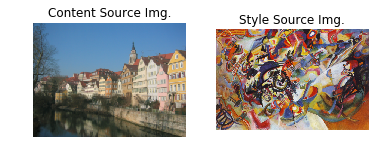

Iteration 0


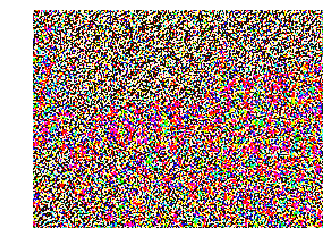

Iteration 100


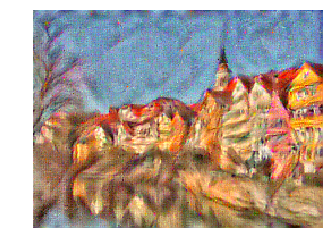

Iteration 199


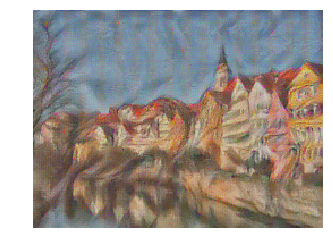

In [19]:
params1 = {
    'content_image' : 'styles/tubingen.jpg',
    'style_image' : 'styles/composition_vii.jpg',
    'image_size' : 192,
    'style_size' : 512,
    'content_layer' : 3,
    'content_weight' : 5e-2,
    'style_layers' : (1,4,6,7),
    'style_weights' : (20000,500,12,1),
    'tv_weight' : 5e-2
}

style_transfer(**params1)

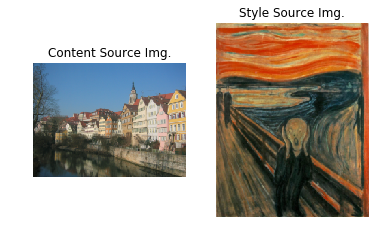

Iteration 0


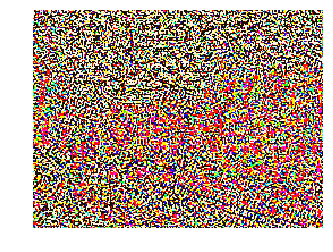

Iteration 100


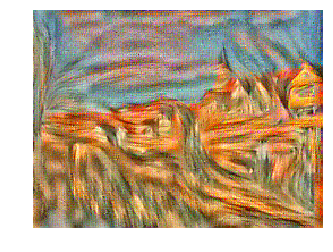

Iteration 199


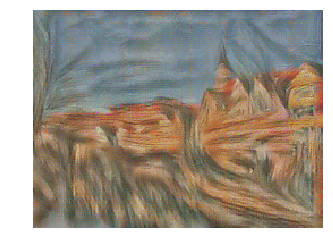

In [20]:
params2 = {
    'content_image' : 'styles/tubingen.jpg',
    'style_image' : 'styles/the_scream.jpg',
    'image_size' : 192,
    'style_size' : 224,
    'content_layer' : 3,
    'content_weight' : 3e-2,
    'style_layers' : (1,4,6,7),
    'style_weights' : (20000,800,12,1),
    'tv_weight' : 2e-2
}

style_transfer(**params2)

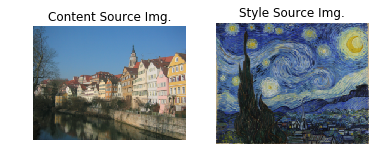

Iteration 0


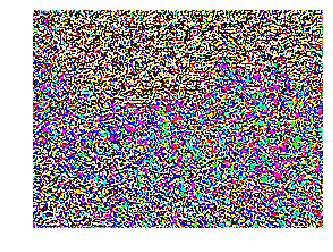

Iteration 100


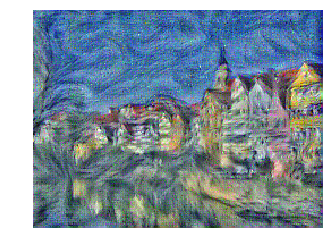

Iteration 199


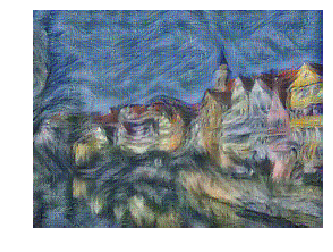

In [21]:
# Starry Night + Tubingen
params3 = {
    'content_image' : 'styles/tubingen.jpg',
    'style_image' : 'styles/starry_night.jpg',
    'image_size' : 192,
    'style_size' : 192,
    'content_layer' : 3,
    'content_weight' : 6e-2,
    'style_layers' : [1, 4, 6, 7],
    'style_weights' : [300000, 1000, 15, 3],
    'tv_weight' : 2e-2
}

style_transfer(**params3)

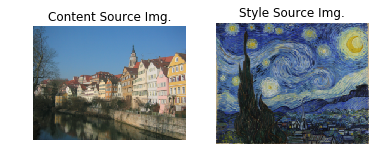

Iteration 0


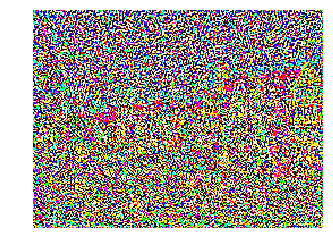

Iteration 100


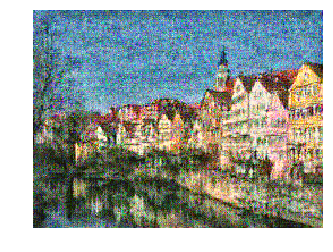

Iteration 199


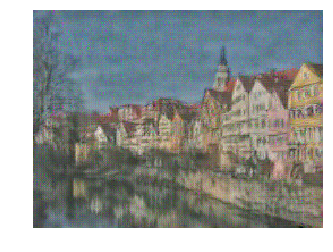

In [22]:
# Feature Inversion -- Starry Night + Tubingen
params_inv = {
    'content_image' : 'styles/tubingen.jpg',
    'style_image' : 'styles/starry_night.jpg',
    'image_size' : 192,
    'style_size' : 192,
    'content_layer' : 3,
    'content_weight' : 6e-2,
    'style_layers' : [1, 4, 6, 7],
    'style_weights' : [0, 0, 0, 0], # we discard any contributions from style to the loss
    'tv_weight' : 2e-2,
    'init_random': True # we want to initialize our image to be random
}

style_transfer(**params_inv)